# Задание 5. Сравнение различных правил распределения итераций между потоками.
Цель данной задачи - сравнить различные способы распределения итераций между потоками. В качестве примера используется поиск максимального элемента каждой из строк нижнетреугольной матрицы размера 100 * 100 элементов с помощью редукции.

### Редукция
В данном подходе использована редукция с оператором `max`. 
```c
static int findMiniMaxReduction(Matrix *matrix)
{
    int maxVal = INT_MIN;
#pragma omp parallel for shared(matrix) reduction(max \
                                                  : maxVal) schedule(runtime)
    for (int i = 0; i < matrix->nRows; i++)
    {
        int rowMin = GetMatrixElem(matrix, i, 0);
        for (int j = 1; j <= i; j++)
        {
            int curr = GetMatrixElem(matrix, i, j);
            if (curr < rowMin)
            {
                rowMin = curr;
            }
        }

        if (rowMin > maxVal)
        {
            maxVal = rowMin;
        }
    }

    return maxVal;
}
```

## Сравнение эффективности алгоритмов


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline

dataset = pd.read_csv("output.csv", sep=';')
dataset = dataset.astype({'method': 'category'})
print(dataset.head(10))


    method  num_threads  elapsed_time
0   single            1        0.0658
1   static            2        0.2339
2  dynamic            2        0.0069
3   guided            2        0.0071
4   static            3        0.0062
5  dynamic            3        0.0067
6   guided            3        0.0068
7   static            4        0.0059
8  dynamic            4        0.0063
9   guided            4        0.0066


Рассчитаем среднее время работы каждого из описанных подходов для каждого из имеющихся методов.

In [2]:
means = dataset.groupby('method').agg({'elapsed_time': 'mean'})

In [3]:
num_elements = dataset.method.unique().tolist()

In [4]:
def visualize(ylabel, title, data):
    print(data.loc['static',:])
    x = np.arange(1)
    width = 0.2

    fig, ax = plt.subplots(figsize=(15, 10))
    rects1 = ax.bar(x - 3*width/2, data.loc['static',:],
                    width, label='Статическое распределение')
    rects2 = ax.bar(x - width/2, data.loc['dynamic',:],
                    width, label='Динамическое распределение')
    rects3 = ax.bar(x + width/2, data.loc['guided',:],
                    width, label='Управляемое распределение')

    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xlabel('Распределение')
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.15f'))
    ax.legend()

    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)
    ax.bar_label(rects3, padding=3)

    fig.tight_layout()


Визуализируем данные. Построим гистограмму среднего времени работы каждого из подходов для каждого из доступных размеров матриц. 

elapsed_time    0.04018
Name: static, dtype: float64


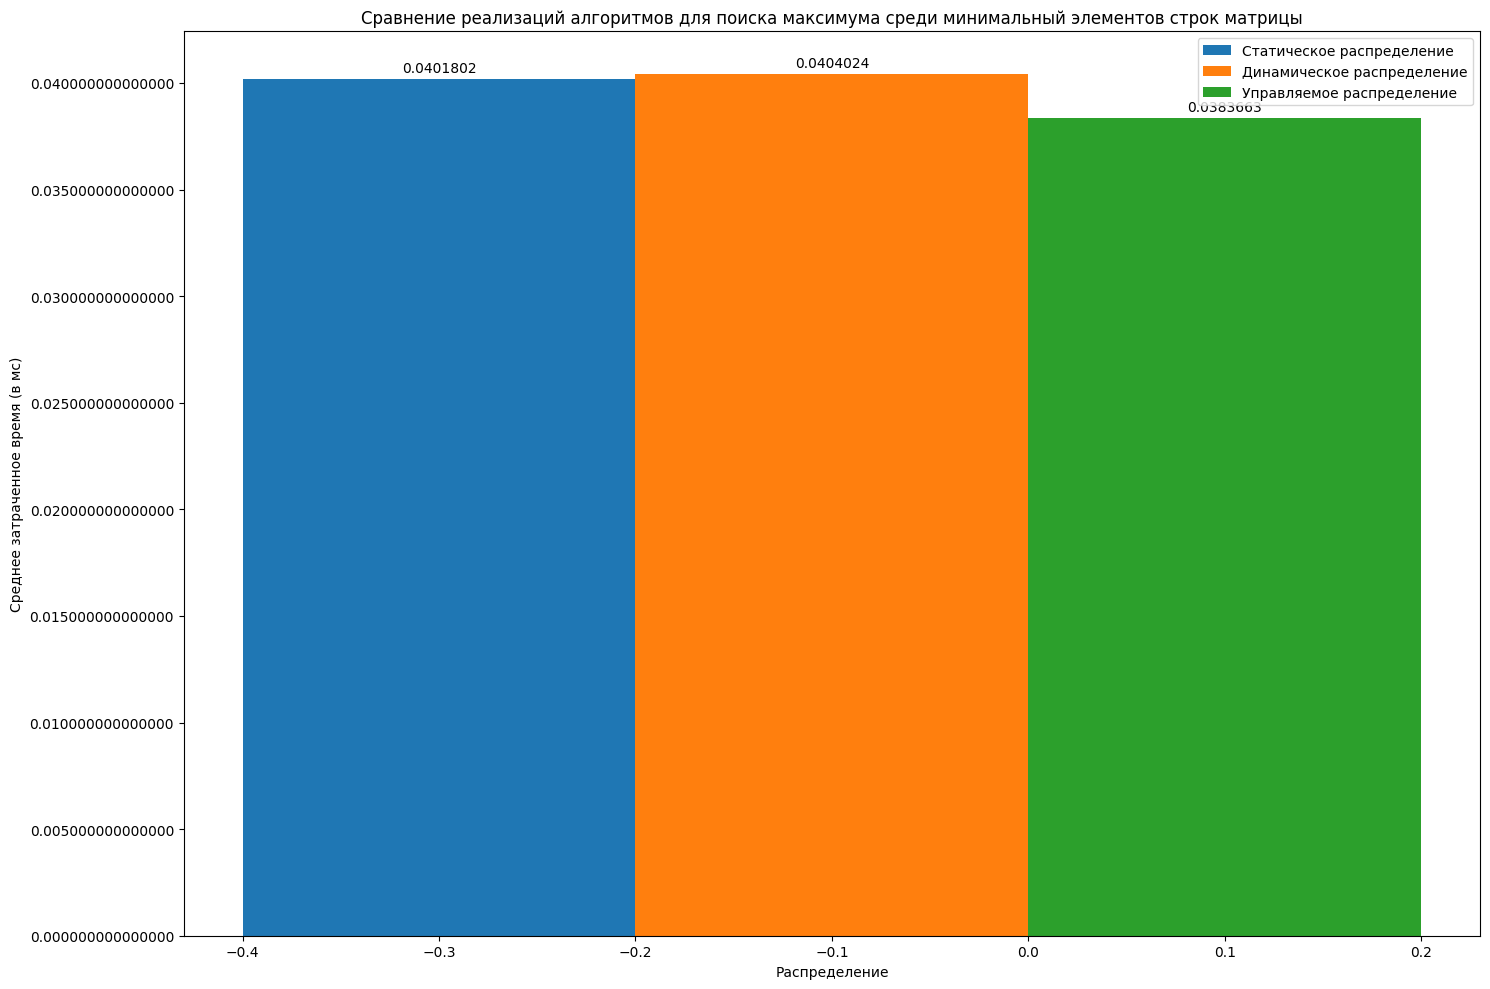

In [5]:
visualize('Среднее затраченное время (в мс)',
          'Сравнение реализаций алгоритмов для поиска максимума среди минимальный элементов строк матрицы', means)


Наиболее эффективным в среднем оказалось управляемое распределение. Наиболее медленным - распределение динамическое. Далее рассмотрим зависимость полученного ускорения от количества потоков.

In [6]:
mean_for_single_thread = dataset.loc[dataset['method']
                                     == 'single', 'elapsed_time'].mean()

means_by_thread_num = dataset.loc[dataset['num_threads'] >= 2, :].groupby(['method', 'num_threads']).agg(
    {'elapsed_time': 'mean'}).reset_index()

means_by_thread_num.loc[:, 'elapsed_time'] = means_by_thread_num.loc[:,
                                                                     'elapsed_time'] / mean_for_single_thread


In [7]:
def visualize_by_thread(data, title):
    labels = dataset.num_threads.unique()[1:]
    x = np.arange(len(labels))
    fig, ax = plt.subplots(figsize=(10, 5))
    static = plt.plot(
        x, data.loc[data['method'] == 'static', 'elapsed_time'], label='Статическое распределение')
    dynamic = plt.plot(
        x, data.loc[data['method'] == 'dynamic', 'elapsed_time'], label='Динамическое распределение')
    guided = plt.plot(
        x, data.loc[data['method'] == 'guided', 'elapsed_time'], label='Управляемое распределение')

    ax.set_xticks(x, labels)
    ax.set_title(title)
    ax.set_xlabel('Количество потоков')
    ax.set_ylabel('Ускорение')
    ax.grid()
    ax.legend()


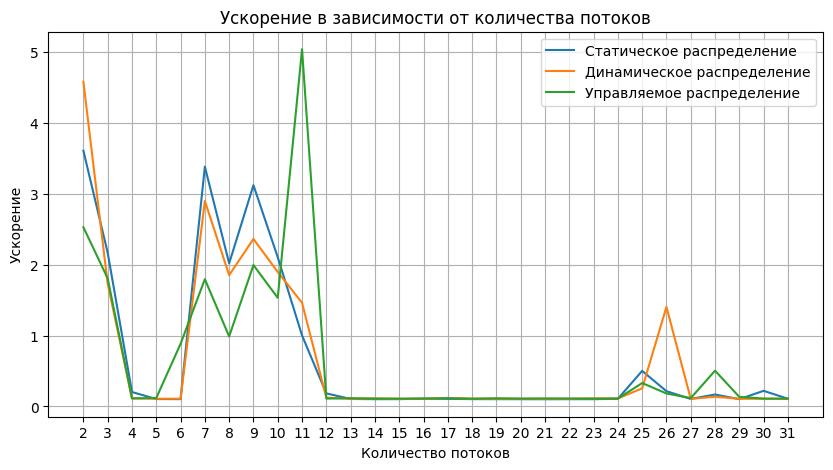

In [8]:
visualize_by_thread(means_by_thread_num,
                'Ускорение в зависимости от количества потоков')


При наличии двух потоков наиболее эффективным оказывается динамическое распределение итераций. При увеличении количества потоков до 4 ускорение снижается практически до 0. При 7 потоках максимальное ускорение в 3 раза дает статическое распределение. При увеличении количества потоков до 11 и использовании управляемого распредления получается добиться наибольшего ускорения в 5 раз. При дальнейшем увеличении количества потоков получаемое ускорение стремится к 0.